In [1]:
import h5py
import jax.numpy as jnp
import numpy as np
import healpy as hp
from functools import partial
import jax

In [2]:
fiducial = True #wether we use fiducial datat or grid dataset

In [3]:
filename = "/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5"
f = h5py.File(filename, "r")

if fiducial: 
    dataset_grid = f["parameters"]["fiducial"]
else: 
    dataset_grid = f['parameters']['grid']


 Because we force the decoder to have the same power spectrum as the gaussian latent space we have to make sure that our nbody sims share the same power spectrum as Gaussian sims for this experiment we use only 1 spherical nobody sim

In [4]:
# config

nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area
xsize = N = 80  # width of figure in pixels
map_size = size = 10 # Size of square in degrees
reso = size * 60 / xsize
master_key = jax.random.PRNGKey(0)

2024-06-29 10:20:11.068908: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfslocalsup/spack_soft/sox/14.4.2/gcc-8.4.1-egb3ni235l3f4q4lxbo3gfqgws6fdecl/lib:/gpfslocalsup/spack_soft/openmpi/4.1.1/gcc-8.5.0-mbafzinnzpvx22cqojowmnmatg2po2aw/lib:/gpfslocalsup/spack_soft/gcc/8.5.0/gcc-11.3.1-kscbdhy5tas2syvclsyjgg2kmqhusdeu/lib64:/gpfslocalsup/spack_soft/gcc/8.5.0/gcc-11.3.1-kscbdhy5tas2syvclsyjgg2kmqhusdeu/lib:/gpfslocalsup/spack_soft/cudnn/8.1.1.33-11.2/gcc-8.3.1-dgsfwc7e23vzc36jopc5nxyunptm2ieh/lib64:/gpfslocalsup/spack_soft/nccl/2.9.6-1/gcc-8.3.1-2c3rwcolksekujszxrg7r72uxmekxx2y/lib:/gpfslocalsys/cuda/11.2/nvvm/lib64:/gpfslocalsys/cuda/11.2/extras/CUPTI/lib64:/gpfslocalsys/cuda/11.2/lib64:/gpfslocalsys/cuda/11.2/samples/common/lib/linux/x86_64:/gpfslocalsys/cuda/11.2/targets/x86_64-linux/lib:/gpfslocalsys/slurm/c

In [5]:
sim_nb = 4 # simulation number from 0 to 6


cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0'],
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T

nb_of_projected_map = 200
master_key = jax.random.PRNGKey(6)
key, master_key = jax.random.split(master_key)
if fiducial: 
    path_string = "/gpfsdswork/dataset/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/"
else:
    path_string = '/gpfsdswork/dataset/' + dataset_grid['path_par'][0].decode('utf-8').replace('CosmoGrid', 'CosmoGridV1').replace('raw', 'stage3_forecast')
filename = path_string + 'perm_000' + str(sim_nb) 
filename_baryon = filename + '/projected_probes_maps_baryonified512.h5'
filename_withouth_baryon = filename + '/projected_probes_maps_nobaryons512.h5'
sim_with_baryon = h5py.File(filename_baryon, "r")
sim_without_baryon = h5py.File(filename_withouth_baryon, "r")


# keeping only last tomo bins
nbody_map_without_baryon = np.array(sim_without_baryon['kg']['stage3_lensing{}'.format(4)])

# building gaussian map
lmax = 3*nside - 1  
power_spectrum_nbody_map = hp.sphtfunc.anafast(nbody_map_without_baryon, lmax = lmax)
z = np.random.randn(hp.nside2npix(nside)) * np.sqrt(scaling_factor) 
power_spectrum_noise =  hp.sphtfunc.anafast(z, lmax = lmax)
power_spectrum_target = power_spectrum_nbody_map / power_spectrum_noise
alm_hp = hp.map2alm(z, lmax = lmax)
alm = hp.sphtfunc.almxfl(alm_hp, np.sqrt(power_spectrum_target))
gaussian_map = hp.alm2map(alm, nside, lmax = lmax)

# projection
key1, key2 = jax.random.split(key)
lon = jax.random.randint(key1,(nb_of_projected_map,),-180, 180)
lat = jax.random.randint(key2, (nb_of_projected_map,), -90, 90)
projection_nbody_store=[]
projection_gaussian_store=[]
for k in range(nb_of_projected_map):
    proj = hp.projector.GnomonicProj(rot=[lon[k], lat[k], 0], xsize=xsize, ysize=xsize, reso=reso)
    projection_nbody = proj.projmap(nbody_map_without_baryon, vec2pix_func=partial(hp.vec2pix, nside))
    projection_nbody_store.append(projection_nbody)
    projection_gaussian = proj.projmap(gaussian_map, vec2pix_func=partial(hp.vec2pix, nside))
    projection_gaussian_store.append(projection_gaussian)

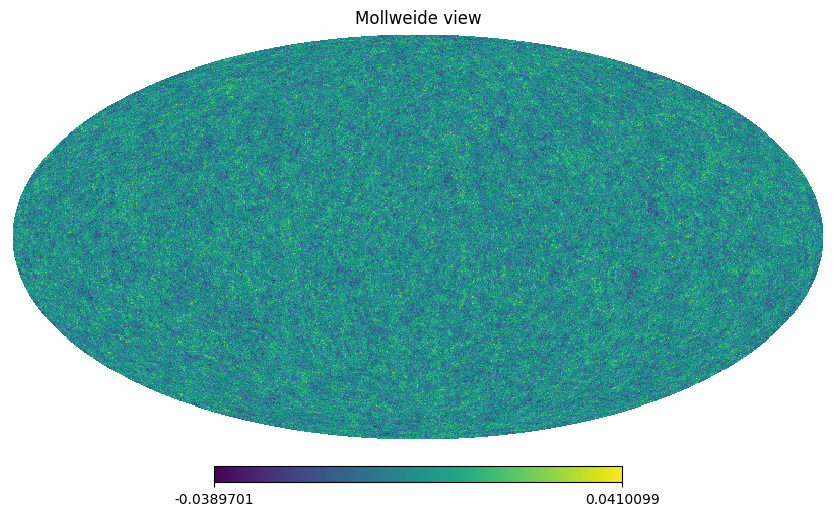

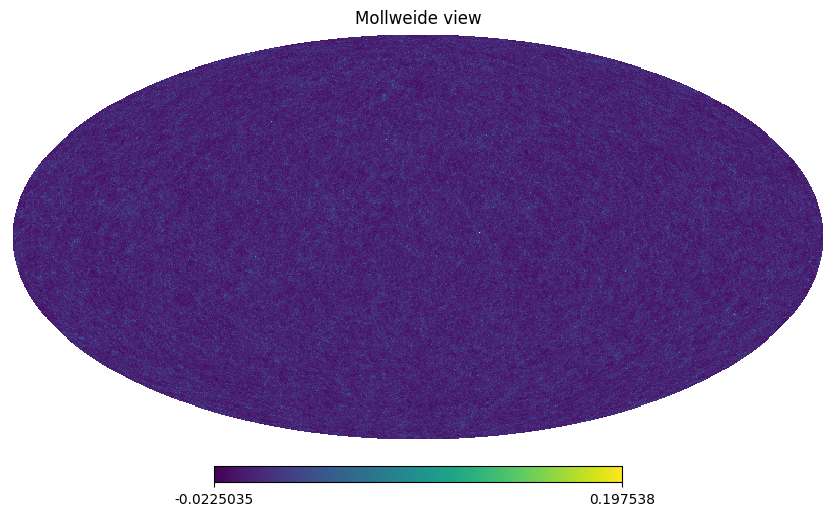

In [6]:
hp.mollview(gaussian_map - gaussian_map.mean())
hp.mollview(nbody_map_without_baryon - nbody_map_without_baryon.mean())

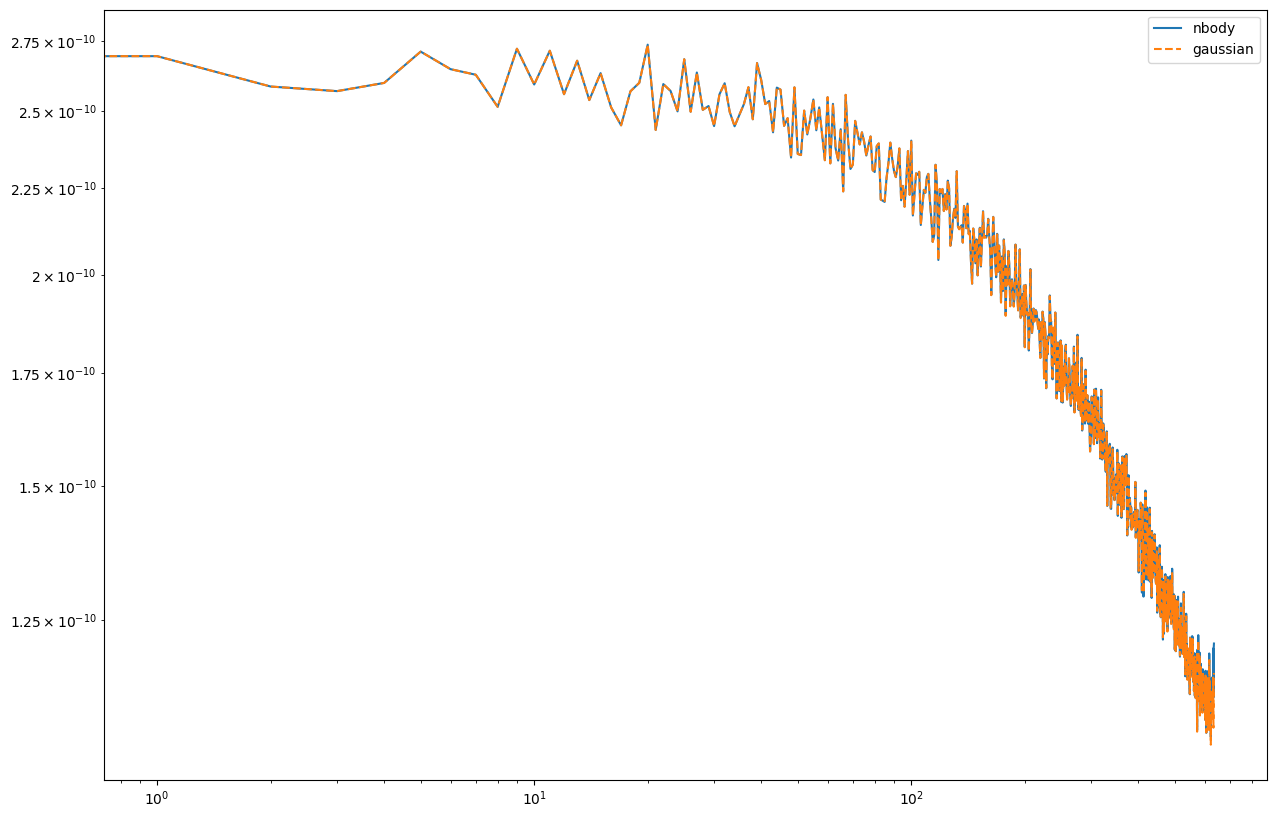

In [7]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,10))
i = 900
power_spectrum_gaussian_map = hp.sphtfunc.anafast(gaussian_map, lmax = lmax)
power_spectrum_nbody_map = hp.sphtfunc.anafast(nbody_map_without_baryon, lmax = lmax)

plt.loglog(power_spectrum_nbody_map[i:], label = 'nbody')
plt.loglog(power_spectrum_gaussian_map[i:], '--',label = 'gaussian')
plt.legend()

Ooooooooook the power spectrums are the same 🥳

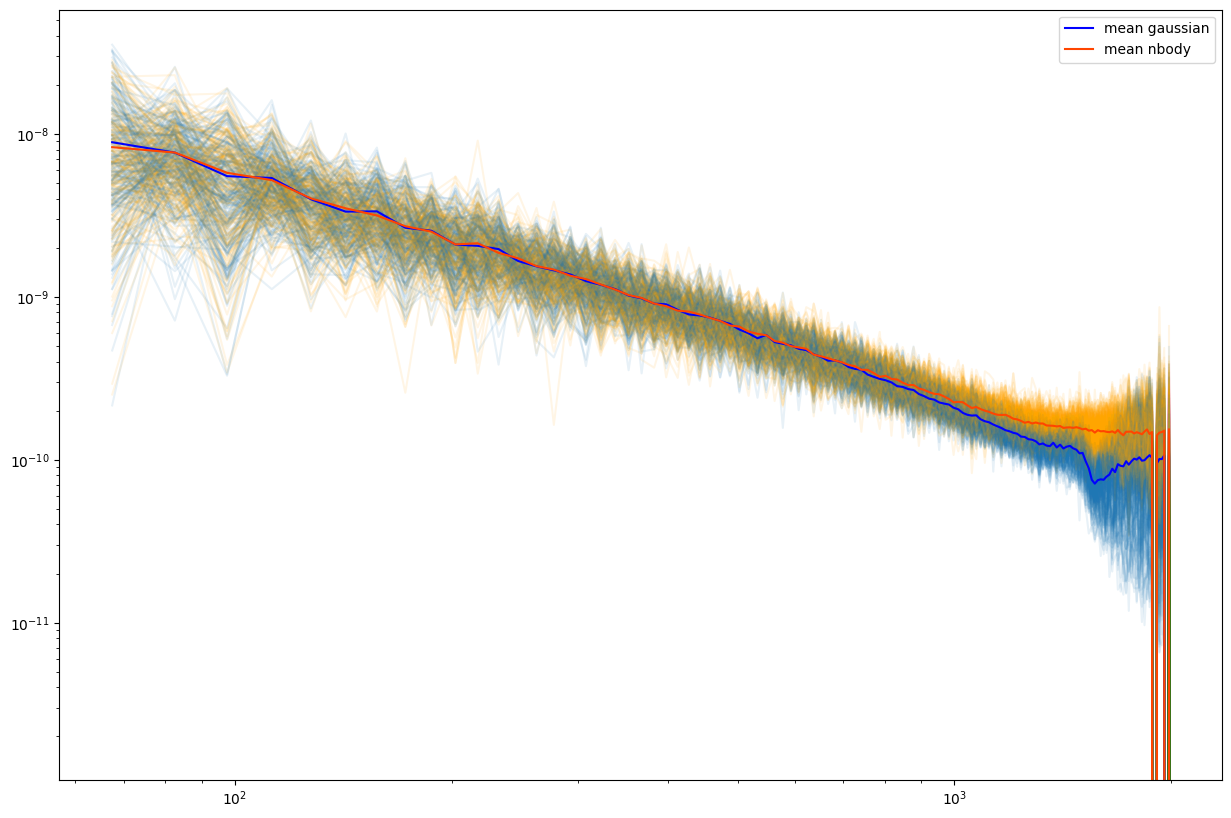

In [14]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(15,10))

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)

store_ps_gaussian = []
store_ps_nbody = []
for i in range(0, nb_of_projected_map):
    ell, ps = ConvergenceMap(projection_gaussian_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = 0.1, color='C0')
    plt.loglog(ell2, ps2, alpha = 0.1, color='orange')

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean gaussian')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.legend()

This is weird, it should be the same after projection 🤔 

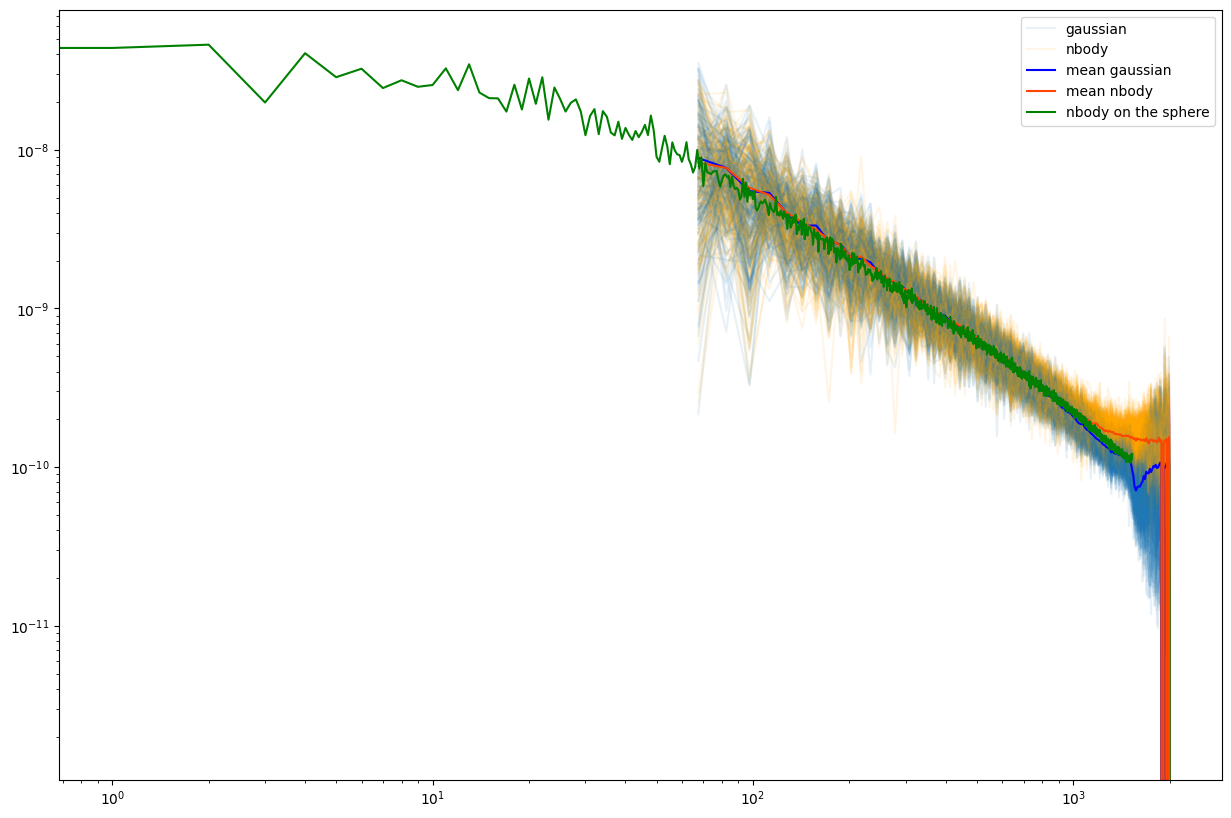

In [15]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(15,10))

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)

ell, ps = ConvergenceMap(projection_gaussian_store[0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
ell2, ps2 = ConvergenceMap(projection_nbody_store[0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
plt.loglog(ell,ps, alpha = 0.1, color='C0', label ='gaussian')
plt.loglog(ell2, ps2, alpha = 0.1, color='orange',label ='nbody')

store_ps_gaussian = []
store_ps_nbody = []
for i in range(1, nb_of_projected_map):
    ell, ps = ConvergenceMap(projection_gaussian_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = 0.1, color='C0')
    plt.loglog(ell2, ps2, alpha = 0.1, color='orange')

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean gaussian')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.legend()

i = 10
plt.loglog(power_spectrum_nbody_map[i:], color='green', label = 'nbody on the sphere')
plt.legend()

Super weird why is the true power spectrum from the map on the sphere closer to the gaussian power spectrum 😩

Ok lets also check how the gaussian prior behaves

In [10]:
from jax.tree_util import register_pytree_node_class
from jax_cosmo.redshift import redshift_distribution
import numpyro.distributions as dist
import jax_cosmo as jc
np.float = float
np.complex = complex


# Create our fiducial observations
pix_area = (map_size * 60 / N) ** 2  # arcmin2
map_size_rad = map_size / 180 * jnp.pi  # radians

galaxy_density = gal_per_arcmin2 = 10/4
sigma_e = 0.26



@register_pytree_node_class
class smail_nz2(redshift_distribution):
    def pz_fn(self, z):
        a, b, z0 = self.params
        return z**a * jnp.exp(-((z / z0) ** b))*4
    
def Pk_fn(k, cosmo, a_ai=None):
    pz = smail_nz2(3.53, 4.49, 1.03, gals_per_arcmin2=galaxy_density)
    tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)


def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    return ps_map * (N / field_size) ** 2

def gaussian_forward_model():
    Om = numpyro.sample("Om", dist.Uniform(0.1,0.5))
    s8 = numpyro.sample("s8", dist.Uniform(0.4,1.4))
    h = numpyro.sample("h", dist.Uniform(0.64, 0.82))
    Ob = numpyro.sample("Ob", dist.Uniform(0.03,0.06))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))
    w0 = numpyro.sample("w0", dist.Uniform(-2.0, -0.333))
    
    z = numpyro.sample(
        "z", dist.MultivariateNormal(loc=jnp.zeros((N, N)), precision_matrix=jnp.eye(N))
    )
    
    cosmo = jc.Planck15(
        Omega_c=Om - Ob,
        Omega_b=Ob,
        h=h,
        n_s=ns,
        sigma8=s8,
        Omega_k=0.0,
        w0=w0,
        wa=0.0,
    )
    
    P = partial(Pk_fn, cosmo=cosmo, a_ai=None)
    power_map = make_power_map(P, N, map_size_rad)
    
    gaussian_map = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real
    x = numpyro.deterministic("x", gaussian_map.squeeze())
    # x = numpyro.sample(
    #     "x",
    #     dist.Independent(
    #         dist.Normal(gaussian_map.squeeze(), sigma_e / jnp.sqrt(gal_per_arcmin2 * pix_area)), 2
    #     ),
    # )
    
    return x

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import numpyro
fiducial_model = numpyro.handlers.condition(
    gaussian_forward_model, 
    {
        "Om": cosmo_parameters[sim_nb][0], 
        "s8": cosmo_parameters[sim_nb][1], 
        "w0": cosmo_parameters[sim_nb][2], 
        "h": cosmo_parameters[sim_nb][3]/100, 
        "ns": cosmo_parameters[sim_nb][4],
        "Ob": cosmo_parameters[sim_nb][5], 
    }
)

@jax.jit
@jax.vmap
def get_sample_prior(key):
    model_trace = numpyro.handlers.trace(seed(fiducial_model, key)).get_trace()
    return model_trace['x']['value']#.mean

In [12]:
from numpyro.handlers import condition, reparam, seed, trace
gaussian_map_prior_store = get_sample_prior(
    jax.random.split(jax.random.PRNGKey(123), nb_of_projected_map)
)

/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genkqu01/uf

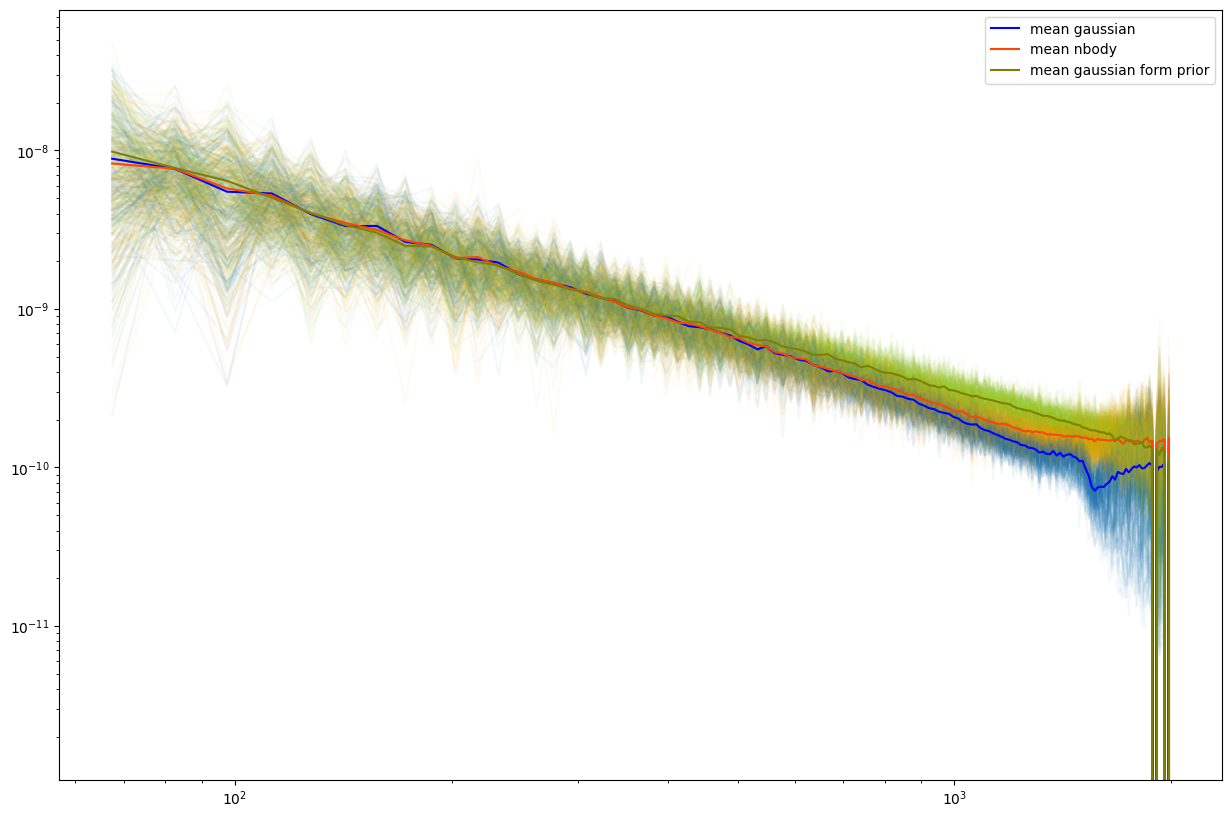

In [16]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(15,10))

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
alpha = 0.05


store_ps_gaussian = []
store_ps_nbody = []
store_ps_gaussian_prior=[]
for i in range(0, nb_of_projected_map):
    ell, ps = ConvergenceMap(projection_gaussian_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = alpha, color='C0')
    plt.loglog(ell2, ps2, alpha = alpha, color='orange')

    l, Pl = ConvergenceMap(gaussian_map_prior_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian_prior.append(Pl)
    plt.loglog(l, Pl, alpha = alpha, c = 'yellowgreen')

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean gaussian')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.loglog(l, jnp.mean(jnp.array(store_ps_gaussian_prior), axis = 0),  color='olive', label = 'mean gaussian form prior')
plt.legend()